In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib.patches import Ellipse

### Use the test with samples drawn from the same distribution - compared to one bootstrap from itself each time

In [2]:
# Network generation --------------------------------------------------------
random.seed(10)
np.random.seed(10)

n = 1000  # number of nodes
K = 4   # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []

B_list.append(np.array([[0.8, 0.1, 0.5, 0.3],
                        [0.4, 0.6, 0.9, 0.2],
                        [0.7, 0.2, 0.4, 0.8],
                        [0.3, 0.5, 0.6, 0.1]]))

In [3]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [4]:
random.seed(100)
np.random.seed(100)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
A_t = np.random.binomial(n=1, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

As = As.astype(int)
P = np.column_stack(P_list)

In [5]:
# Generate more samples from the same model with the same parameters (P matrix)
random.seed(100)
np.random.seed(100)

M=200
A_true_draws = []

for m in range(M):
    # Generate random graph from the P matrix
    A_t = np.random.binomial(n=1, p=P_t)
    # turn to integer from float
    A_t = A_t.astype(float)
    As = A_t

    As = As.astype(float)

    A_true_draws.append(As)

In [6]:
d=4

### 1 kNN bootstrap for each draw from the model, $k=5$

In [26]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=5)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

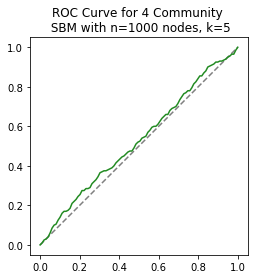

In [31]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes, k=5")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_knnBootstrap_k5_M200.png")

plt.show()

In [ ]:
# p_hat_list = p_vals
# roc = []
# alphas = []

# for alpha in np.linspace(0, 1, 100):
#     alphas.append(alpha)
#     num_below_alpha = sum(p_hat_list < alpha)
#     roc_point = num_below_alpha / len(p_hat_list)
#     roc.append(roc_point)

# # Get the power at the 5% significance level
# power_significance = 0.05
# power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
# power = roc[power_idx]

# # Calculate the area between ROC and y=x line

# def compute_area_above_below_curve(x, y):
#     area_above = 0.0
#     area_below = 0.0
    
#     for i in range(1, len(x)):
#         x0, x1 = x[i - 1], x[i]
#         y0, y1 = y[i - 1], y[i]
#         line0, line1 = x0, x1  # Since line y = x
        
#         if y1 == y0:  # Vertical segment
#             if y0 > x0:
#                 area_above += (y0 - x0) * (x1 - x0)
#             else:
#                 area_below += (x0 - y0) * (x1 - x0)
#             continue
        
#         # Find intersection with y = x
#         if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
#             if y0 >= x0 and y1 >= x1:
#                 area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
#             else:
#                 area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
#         else:
#             x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
#             if y0 < x0:
#                 area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
#                 area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
#             else:
#                 area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
#                 area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
#     return area_above, area_below

# x = np.linspace(0, 1, 100)
# roc_interpolated = np.interp(x, alphas, roc)

# # Compute areas
# area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
# total_area = area_above + area_below

# print(f"Area above the y=x line: {area_above}")
# print(f"Area below the y=x line: {area_below}")
# print(f"Total area (above and below y=x): {total_area}")

In [ ]:
def compute_roc_and_areas(p_hat_list, significance_level=0.05):
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the significance level
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - significance_level)))
    power = roc[power_idx]

    # Calculate the area between ROC and y=x line
    def compute_area_above_below_curve(x, y):
        area_above = 0.0
        area_below = 0.0

        for i in range(1, len(x)):
            x0, x1 = x[i - 1], x[i]
            y0, y1 = y[i - 1], y[i]
            line0, line1 = x0, x1  # Since line y = x

            if y1 == y0:  # Vertical segment
                if y0 > x0:
                    area_above += (y0 - x0) * (x1 - x0)
                else:
                    area_below += (x0 - y0) * (x1 - x0)
                continue

            # Find intersection with y = x
            if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
                if y0 >= x0 and y1 >= x1:
                    area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
                else:
                    area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
            else:
                x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
                if y0 < x0:
                    area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                    area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
                else:
                    area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                    area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)

        return area_above, area_below

    x = np.linspace(0, 1, 100)
    roc_interpolated = np.interp(x, alphas, roc)

    # Compute areas
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below

    return {
        "area_above": area_above,
        "area_below": area_below,
        "total_area": total_area
    }

In [32]:
compute_roc_and_areas(p_vals, significance_level=0.05)

{'area_above': 0.029548104931229068,
 'area_below': 0.0002512816496083546,
 'total_area': 0.029799386580837424}

#### Some measures of variance estimation per node quality 

Here have M true draws, and select one true draw from which to sample B bootstrap matrices
I choose B=M-1, so each estimate of variance has the same number of networks to use. 

Variance estimation via MSE, Frobenius norm, spectral norm, e-value comparison

In [20]:
# make a list of M true draws and M-1 bootstrap samples from the first true draw

# all the true draws first
A_true_boots_list = A_true_draws

# then all the bootstrap samples of one matrix
m = A_true_draws[0]
# for i in range(M-1):
#     p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=5)
#     A_true_boots_list.append(A_boots)

A_true_boots_list = knn_bootstraps(m, d=d, B=M-1, embedding_function=UASE, sparse_matrix=True)

len(A_true_boots_list)

Embedding the graph...
Estimating the P matrix...


/home/uj21900/anaconda3/lib/python3.9/site-packages/numba/typed/typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  d[key] = value


Generating bootstraps...


100%|██████████| 199/199 [01:39<00:00,  2.00it/s]


199

In [22]:
np.sum(m)

470021.0

In [24]:
# embed into d=4 dimensions (as rank(P) = 4)
yhat_A_true_boots = UASE(A_true_boots_list, d=4, sparse_matrix=False)

In [23]:
# embed into d=4 dimensions (as rank(P) = 4)

# from scipy import sparse

# for i in range(0, len(A_true_boots_list)):
#     A_true_boots_list[i] = sparse.csr_matrix(A_true_boots_list[i])

yhat_A_true_boots = UASE(A_true_boots_list, d=4, sparse_matrix=True)

In [25]:
yadf = pd.DataFrame(yhat_A_true_boots)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (tau.tolist())*(len(A_true_boots_list))

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(len(A_true_boots_list)), n)

# add a column for the type of data
yadf['TrueSample'] = [1]*n*M + [0]*n*(M-1)

# give nodes a number
yadf["NodeNumber"] = np.tile(range(n), (2*M)-1)

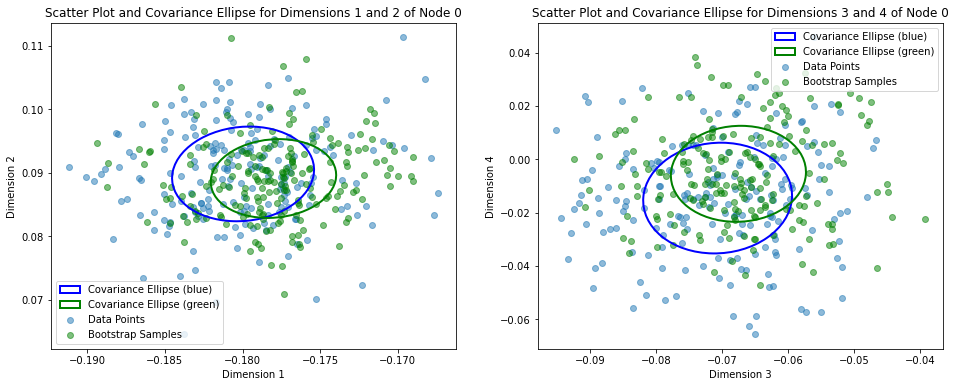

In [27]:
"""Plot for a specific node"""

node_number = 0

# Plot the points and covariance matrix
fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 6))

data_true = yadf[(yadf["TrueSample"] == 1) & (yadf["NodeNumber"] == node_number)].iloc[:, 0:d].to_numpy()
data_boots = yadf[((yadf["TrueSample"] == 0) & (yadf["NodeNumber"] == node_number) ) | ((yadf['Matrix'] == 0) & (yadf["NodeNumber"] == node_number))].iloc[:, 0:d].to_numpy()

# Calculate the mean and covariance considering all d dimensions
mean_d_dim = np.mean(data_true, axis=0)
cov_d_dim = np.cov(data_true, rowvar=False)
mean_boots_d_dim = np.mean(data_boots, axis=0)
cov_boots_d_dim = np.cov(data_boots, rowvar=False)

# Eigen decomposition of the covariance matrix (considering all d dimensions)
eigenvalues, eigenvectors = np.linalg.eigh(cov_d_dim)
order = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[order]
eigenvectors = eigenvectors[:, order]

eigenvalues_boots, eigenvectors_boots = np.linalg.eigh(cov_boots_d_dim)
order_boots = eigenvalues_boots.argsort()[::-1]
eigenvalues_boots = eigenvalues_boots[order_boots]
eigenvectors_boots = eigenvectors_boots[:, order_boots]

def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)

# Plotting the first 2 dimensions
ax = axes[0]
data_2d = data_true[:, 0:2]
data_boots_2d = data_boots[:, 0:2]
ax.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.5, label='Data Points')
ax.scatter(data_boots_2d[:, 0], data_boots_2d[:, 1], alpha=0.5, label='Bootstrap Samples', color='g')
plot_ellipse(ax, mean_d_dim[:2], cov_d_dim[:2, :2], 'blue')
plot_ellipse(ax, mean_boots_d_dim[:2], cov_boots_d_dim[:2, :2], 'green')
ax.set_title(f'Scatter Plot and Covariance Ellipse for Dimensions 1 and 2 of Node {node_number}')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

# Plotting the 3rd and 4th dimensions
ax = axes[1]
data_3d = data_true[:, 2:4]
data_boots_3d = data_boots[:, 2:4]
ax.scatter(data_3d[:, 0], data_3d[:, 1], alpha=0.5, label='Data Points')
ax.scatter(data_boots_3d[:, 0], data_boots_3d[:, 1], alpha=0.5, label='Bootstrap Samples', color='g')
plot_ellipse(ax, mean_d_dim[2:4], cov_d_dim[2:4, 2:4], 'blue')
plot_ellipse(ax, mean_boots_d_dim[2:4], cov_boots_d_dim[2:4, 2:4], 'green')
ax.set_title(f'Scatter Plot and Covariance Ellipse for Dimensions 3 and 4 of Node {node_number}')
ax.set_xlabel('Dimension 3')
ax.set_ylabel('Dimension 4')
ax.legend()

plt.show()


In [32]:
MSE_cov_knn_list = []   
MSE_mean_knn_list = []

for i in range(M):
    node_number = i

    data_true = yadf[(yadf["TrueSample"] == 1) & (yadf["NodeNumber"] == node_number)].iloc[:, 0:d].to_numpy()
    data_boots = yadf[((yadf["TrueSample"] == 0) & (yadf["NodeNumber"] == node_number) ) | ((yadf['Matrix'] == 0) & (yadf["NodeNumber"] == node_number))].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_true, axis=0)
    cov_d_dim = np.cov(data_true, rowvar=False)
    mean_boots_d_dim = np.mean(data_boots, axis=0)
    cov_boots_d_dim = np.cov(data_boots, rowvar=False)

    # calculate the MSE between cov_d_dim and cov_boots_d_dim
    MSE = np.mean((cov_d_dim - cov_boots_d_dim)**2)
    MSE_cov_knn_list.append(MSE)
    # calculate the MSE between mean_d_dim and mean_boots_d_dim
    MSE = np.mean((mean_d_dim - mean_boots_d_dim)**2)
    MSE_mean_knn_list.append(MSE)

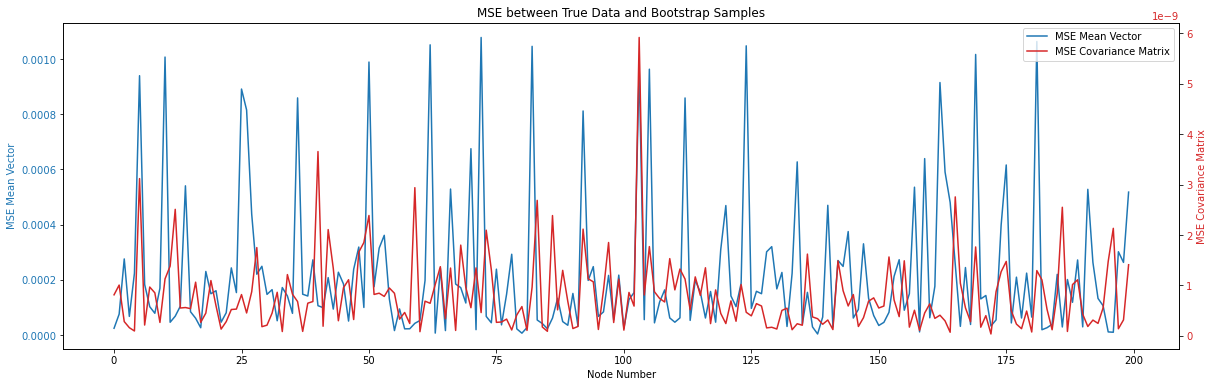

In [39]:
# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot MSE for Mean Vector
color = 'tab:blue'
ax1.set_xlabel('Node Number')
ax1.set_ylabel('MSE Mean Vector', color=color)
ax1.plot(MSE_mean_knn_list, color=color, label='MSE Mean Vector')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot MSE for Covariance Matrix
color = 'tab:red'
ax2.set_ylabel('MSE Covariance Matrix', color=color)
ax2.plot(MSE_cov_knn_list, color=color, label='MSE Covariance Matrix')
ax2.tick_params(axis='y', labelcolor=color)

# Title
plt.title('MSE between True Data and Bootstrap Samples')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Show plot
plt.show()

In [40]:
print(f"Average MSE for Mean Vector: {np.mean(MSE_mean_knn_list)}, Average MSE for Covariance Matrix: {np.mean(MSE_cov_knn_list)}")

Average MSE for Mean Vector: 0.000228566111606995, Average MSE for Covariance Matrix: 8.064470023072742e-10


### 1 kNN bootstrap for each draw from the model, $k=2$

In [15]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=2)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

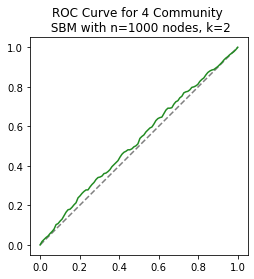

In [16]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes, k=2")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_knnBootstrap_k2_M200.png")

plt.show()

### 1 kNN bootstrap for each draw from the model, $k=25$

In [23]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_k25 = []
A_boots_list_k25 = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=25)
    p_vals_k25.append(p_val)
    A_boots_list_k25.append(A_boots)

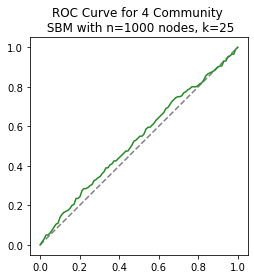

{'area_above': 0.03314588338233883,
 'area_below': 0.0002933039197195947,
 'total_area': 0.03343918730205842}

In [25]:
p_hat_list = p_vals_k25
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes, k=25")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_knnBootstrap_k25_M200.png", facecolor="white")

plt.show()


compute_roc_and_areas(p_vals_k25, significance_level=0.05)

variance estimation stuff

In [9]:
# make a list of M true draws and M-1 bootstrap samples from the first true draw

# all the true draws first
A_true_boots_list_k25 = A_true_draws

# then all the bootstrap samples of one matrix
m = A_true_draws[0]
for i in range(M-1):
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=25)
    A_true_boots_list_k25.append(A_boots)

In [10]:
# embed into d=4 dimensions (as rank(P) = 4)
yhat_A_true_boots = UASE(A_true_boots_list_k25, d=4, sparse_matrix=False)

In [12]:
yadf = pd.DataFrame(yhat_A_true_boots)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (tau.tolist())*(len(A_true_boots_list_k25))

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(len(A_true_boots_list_k25)), n)

# add a column for the type of data
yadf['TrueSample'] = [1]*n*M + [0]*n*(M-1)

# give nodes a number
yadf["NodeNumber"] = np.tile(range(n), (2*M)-1)

In [13]:
MSE_cov_knn_list_k25 = []   
MSE_mean_knn_list_k25 = []

for i in range(M):
    node_number = i

    data_true = yadf[(yadf["TrueSample"] == 1) & (yadf["NodeNumber"] == node_number)].iloc[:, 0:d].to_numpy()
    data_boots = yadf[((yadf["TrueSample"] == 0) & (yadf["NodeNumber"] == node_number) ) | ((yadf['Matrix'] == 0) & (yadf["NodeNumber"] == node_number))].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_true, axis=0)
    cov_d_dim = np.cov(data_true, rowvar=False)
    mean_boots_d_dim = np.mean(data_boots, axis=0)
    cov_boots_d_dim = np.cov(data_boots, rowvar=False)

    # calculate the MSE between cov_d_dim and cov_boots_d_dim
    MSE = np.mean((cov_d_dim - cov_boots_d_dim)**2)
    MSE_cov_knn_list_k25.append(MSE)
    # calculate the MSE between mean_d_dim and mean_boots_d_dim
    MSE = np.mean((mean_d_dim - mean_boots_d_dim)**2)
    MSE_mean_knn_list_k25.append(MSE)

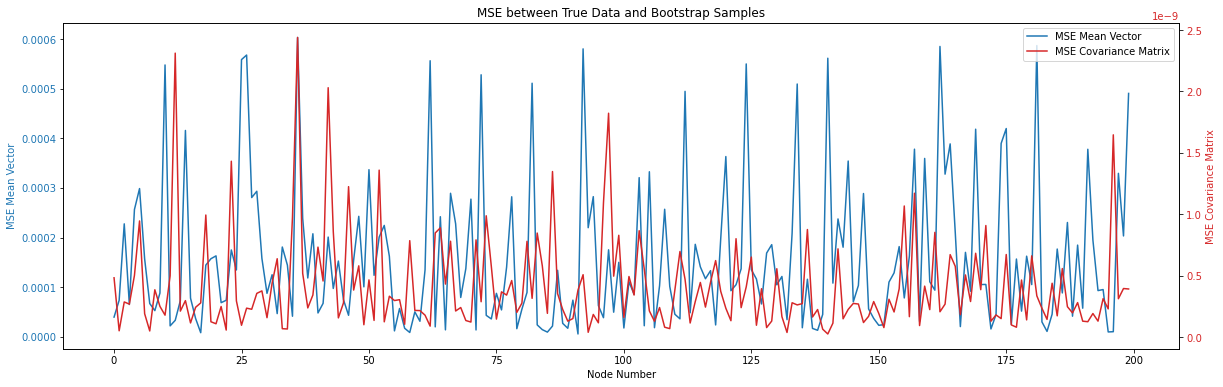

In [14]:
# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot MSE for Mean Vector
color = 'tab:blue'
ax1.set_xlabel('Node Number')
ax1.set_ylabel('MSE Mean Vector', color=color)
ax1.plot(MSE_mean_knn_list_k25, color=color, label='MSE Mean Vector')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot MSE for Covariance Matrix
color = 'tab:red'
ax2.set_ylabel('MSE Covariance Matrix', color=color)
ax2.plot(MSE_cov_knn_list_k25, color=color, label='MSE Covariance Matrix')
ax2.tick_params(axis='y', labelcolor=color)

# Title
plt.title('MSE between True Data and Bootstrap Samples')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Show plot
plt.show()

In [15]:
print(f"Average MSE for Mean Vector: {np.mean(MSE_mean_knn_list_k25)}, Average MSE for Covariance Matrix: {np.mean(MSE_cov_knn_list_k25)}")

Average MSE for Mean Vector: 0.00015927670386114536, Average MSE for Covariance Matrix: 4.12307245016708e-10


### 1 kNN bootstrap for each draw from the model, $k=240$

In [29]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_k240 = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=240)
    p_vals_k240.append(p_val)
    A_boots_list.append(A_boots)

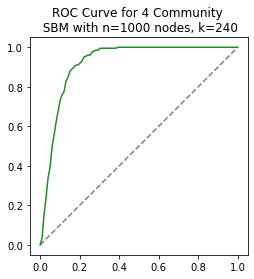

{'area_above': 0.4228139985715743,
 'area_below': 0.0,
 'total_area': 0.4228139985715743}

In [30]:
p_hat_list = p_vals_k240
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes, k=240")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_knnBootstrap_k240_M200.png", facecolor="white")

plt.show()

compute_roc_and_areas(p_vals_k240, significance_level=0.05)

variance estimation stuff

In [16]:
# make a list of M true draws and M-1 bootstrap samples from the first true draw

# all the true draws first
A_true_boots_list_k240 = A_true_draws

# then all the bootstrap samples of one matrix
m = A_true_draws[0]
for i in range(M-1):
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=240)
    A_true_boots_list_k240.append(A_boots)

In [ ]:
# embed into d=4 dimensions (as rank(P) = 4)
yhat_A_true_boots = UASE(A_true_boots_list_k240, d=4, sparse_matrix=False)

In [ ]:
yadf = pd.DataFrame(yhat_A_true_boots)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (tau.tolist())*(len(A_true_boots_list_k240))

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(len(A_true_boots_list_k240)), n)

# add a column for the type of data
yadf['TrueSample'] = [1]*n*M + [0]*n*(M-1)

# give nodes a number
yadf["NodeNumber"] = np.tile(range(n), (2*M)-1)

In [ ]:
MSE_cov_knn_list_k240 = []   
MSE_mean_knn_list_k240 = []

for i in range(M):
    node_number = i

    data_true = yadf[(yadf["TrueSample"] == 1) & (yadf["NodeNumber"] == node_number)].iloc[:, 0:d].to_numpy()
    data_boots = yadf[((yadf["TrueSample"] == 0) & (yadf["NodeNumber"] == node_number) ) | ((yadf['Matrix'] == 0) & (yadf["NodeNumber"] == node_number))].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_true, axis=0)
    cov_d_dim = np.cov(data_true, rowvar=False)
    mean_boots_d_dim = np.mean(data_boots, axis=0)
    cov_boots_d_dim = np.cov(data_boots, rowvar=False)

    # calculate the MSE between cov_d_dim and cov_boots_d_dim
    MSE = np.mean((cov_d_dim - cov_boots_d_dim)**2)
    MSE_cov_knn_list_k240.append(MSE)
    # calculate the MSE between mean_d_dim and mean_boots_d_dim
    MSE = np.mean((mean_d_dim - mean_boots_d_dim)**2)
    MSE_mean_knn_list_k240.append(MSE)

In [ ]:
# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot MSE for Mean Vector
color = 'tab:blue'
ax1.set_xlabel('Node Number')
ax1.set_ylabel('MSE Mean Vector', color=color)
ax1.plot(MSE_mean_knn_list_k240, color=color, label='MSE Mean Vector')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot MSE for Covariance Matrix
color = 'tab:red'
ax2.set_ylabel('MSE Covariance Matrix', color=color)
ax2.plot(MSE_cov_knn_list_k240, color=color, label='MSE Covariance Matrix')
ax2.tick_params(axis='y', labelcolor=color)

# Title
plt.title('MSE between True Data and Bootstrap Samples')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Show plot
plt.show()

### $XY^T$ bootstrap for each draw from the model

In [33]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_XYT = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_parametric_bootstrap_cropPto0_1range(m,d=d,Q=1000)
    p_vals_XYT.append(p_val)
    A_boots_list.append(A_boots)

/home/uj21900/Documents/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")


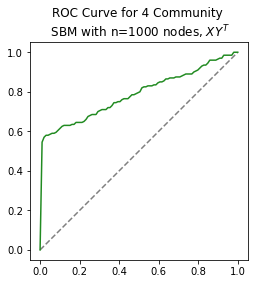

{'area_above': 0.2892643607795121,
 'area_below': 0.0,
 'total_area': 0.2892643607795121}

In [34]:
p_hat_list = p_vals_XYT
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes, $XY^T$")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_XYTbootstrap_M200.png")
plt.show()

compute_roc_and_areas(p_vals_XYT, significance_level=0.05)

variance estimation stuff

In [ ]:
# make a list of M true draws and M-1 bootstrap samples from the first true draw

# all the true draws first
A_true_boots_list_XYT = A_true_draws

# then all the bootstrap samples of one matrix
m = A_true_draws[0]
for i in range(M-1):
    p_val, A_boots = create_single_parametric_bootstrap_cropPto0_1range(m,d=d,Q=1000)
    A_true_boots_list_XYT.append(A_boots)

In [ ]:
# embed into d=4 dimensions (as rank(P) = 4)
yhat_A_true_boots = UASE(A_true_boots_list_XYT, d=4, sparse_matrix=False)

In [ ]:
yadf = pd.DataFrame(yhat_A_true_boots)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (tau.tolist())*(len(A_true_boots_list_XYT))

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(len(A_true_boots_list_XYT)), n)

# add a column for the type of data
yadf['TrueSample'] = [1]*n*M + [0]*n*(M-1)

# give nodes a number
yadf["NodeNumber"] = np.tile(range(n), (2*M)-1)

In [ ]:
MSE_cov_knn_list_XYT = []   
MSE_mean_knn_list_XYT = []

for i in range(M):
    node_number = i

    data_true = yadf[(yadf["TrueSample"] == 1) & (yadf["NodeNumber"] == node_number)].iloc[:, 0:d].to_numpy()
    data_boots = yadf[((yadf["TrueSample"] == 0) & (yadf["NodeNumber"] == node_number) ) | ((yadf['Matrix'] == 0) & (yadf["NodeNumber"] == node_number))].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_true, axis=0)
    cov_d_dim = np.cov(data_true, rowvar=False)
    mean_boots_d_dim = np.mean(data_boots, axis=0)
    cov_boots_d_dim = np.cov(data_boots, rowvar=False)

    # calculate the MSE between cov_d_dim and cov_boots_d_dim
    MSE = np.mean((cov_d_dim - cov_boots_d_dim)**2)
    MSE_cov_knn_list_XYT.append(MSE)
    # calculate the MSE between mean_d_dim and mean_boots_d_dim
    MSE = np.mean((mean_d_dim - mean_boots_d_dim)**2)
    MSE_mean_knn_list_XYT.append(MSE)

In [ ]:
# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot MSE for Mean Vector
color = 'tab:blue'
ax1.set_xlabel('Node Number')
ax1.set_ylabel('MSE Mean Vector', color=color)
ax1.plot(MSE_mean_knn_list_XYT, color=color, label='MSE Mean Vector')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot MSE for Covariance Matrix
color = 'tab:red'
ax2.set_ylabel('MSE Covariance Matrix', color=color)
ax2.plot(MSE_cov_knn_list_XYT, color=color, label='MSE Covariance Matrix')
ax2.tick_params(axis='y', labelcolor=color)

# Title
plt.title('MSE between True Data and Bootstrap Samples')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Show plot
plt.show()

### Sample edgelist with replacement bootstrap for each draw from the model

This is essentially just dropping some edges, as any edge selected more than once is set to a 1 as this is a binary setting

In [36]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_ESWR = []
A_boots_list = []

Q=1000 # number of sims to do in the paired exch test

for m in A_true_draws:
    A_boots = edgelist_sample_with_replacement(m) 
    # embed the observed and bootstrapped matrix together
    yhat_est = UASE([m, A_boots], d=d)
    # do a test between the obs and the bootstrap, get a p-value ---------------------------------
    p_val = test_temporal_displacement_two_times(yhat_est, n=m.shape[0], n_sim=Q) 

    p_vals_ESWR.append(p_val)
    A_boots_list.append(A_boots[0])

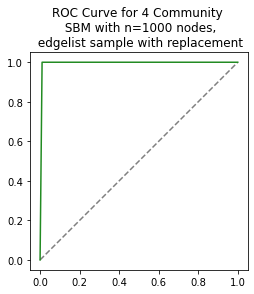

{'area_above': 0.4999489847974696,
 'area_below': 0.0,
 'total_area': 0.4999489847974696}

In [37]:
p_hat_list = p_vals_ESWR
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes,\n edgelist sample with replacement")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_edgelistSampleRepBootstrap_M200.png")

plt.show()

compute_roc_and_areas(p_vals_ESWR, significance_level=0.05)

### Sample edgelist with replacement bootstrap for each draw from the model, then sample random edges to create a bootstrap with the same number of edges

In [38]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals_ESWR_plusRand = []
A_boots_list = []

Q=1000 # number of sims to do in the paired exch test

for m in A_true_draws:
    A_boots = edgelist_sample_with_replacement_addRandomEdges(m) 
    # embed the observed and bootstrapped matrix together
    yhat_est = UASE([m, A_boots], d=d)
    # do a test between the obs and the bootstrap, get a p-value ---------------------------------
    p_val = test_temporal_displacement_two_times(yhat_est, n=m.shape[0], n_sim=Q) 

    p_vals_ESWR_plusRand.append(p_val)
    A_boots_list.append(A_boots[0])

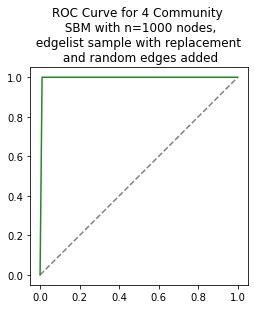

{'area_above': 0.4999489847974696,
 'area_below': 0.0,
 'total_area': 0.4999489847974696}

In [39]:
p_hat_list = p_vals_ESWR_plusRand
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes,\n edgelist sample with replacement \n and random edges added")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_edgelistSampleRepBootstrap_edgesAdded_M200.png")

plt.show()

compute_roc_and_areas(p_vals_ESWR_plusRand, significance_level=0.05)

In [27]:
def edgelist_sample_with_replacement_addRandomEdges_v2(A):
    """Samples edges with replacement and ensures that the bootstrapped matrix has the same number of edges.
    In a binary setting, any edge selected more than once will be set to 1.
    Random edges will be populated so that the observed and the bootstrapped matrix have the same number of edges.
    """
    number_edges = np.count_nonzero(A)
    # find the edge locations
    edges = np.transpose(np.nonzero(A))
    n = A.shape[0]
    
    # sample the edges with replacement
    sampled_edges = edges[random.choices(range(len(edges)), k=number_edges)]
    
    # create A_new and set sampled edges to 1
    A_new = np.zeros((n, n), dtype=int)
    A_new[sampled_edges[:, 0], sampled_edges[:, 1]] = 1
    
    # add in random edges
    missing_edges = number_edges - np.count_nonzero(A_new)
    while missing_edges > 0:
        i, j = np.random.randint(0, n, size=2)
        if A_new[i, j] == 0:
            A_new[i, j] = 1
            missing_edges -= 1
    
    return A_new